# Machine Learning Project - Car Price Prediction

## **Introduction**
The project is based on a dataset containing approximately 40,000 examples of used cars sold in the United Kingdom, provided via the CSV file `car_prices.csv`.

## **Objective**
The goal of the project is to train and evaluate the following models to predict the selling price of used cars:

- k-nearest neighbors
- Linear Regression
- Random Forest Regressor
- Neural Network

The metrics used for performance comparison are:
- Mean Absolute Error (MAE)
- R² Score

## **Dataset**

The dataset contains the following columns:

| Colonna      | Descrizione                               |
|--------------|-------------------------------------------|
| manufacturer | Casa produttrice                          |
| model        | Modello                                   |
| year         | Anno di produzione                        |
| transmission | Cambio automatico/manuale                 |
| mileage      | Miglia percorse                           |
| fuelType     | Alimentazione (e.g., benzina, diesel)     |
| mpg          | Consumo stimato (miglia per gallone)      |
| engineSize   | Cilindrata                                |
| price        | Prezzo di vendita (target della predizione)|

## **Imports**

In [ ]:
!pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import HeNormal, GlorotNormal
from keras_tuner import HyperParameters, RandomSearch
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

##**Utility function**
The function enhances the interpretability and evaluation of model performance.

In [ ]:
def modelresults(y_test, y_pred):
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print('Model results:')
    print('Mean Absolute Error (MAE): {:.4f}'.format(mae))
    print('R^2 Score: {:.4f}'.format(r2))
    print('')

    # Return metrics
    return {
        'MAE': mae,
        'R2': r2
    }

## **Data Preparation**

1. Loading the dataset from a URL
2. Separating the features from the target variable (price)
3. Analyzing the data types in the features and their distribution
4. Splitting the dataset

These steps help prepare the data for subsequent analysis and training of regression models.

###Caricamento del dataset da URL

In [ ]:
#loading dataset
url = "https://raw.githubusercontent.com/RobertoFardella/ML-Project/main/car_prices.csv"
df = pd.read_csv(url)

# Informazioni generali
print(df.info())

# Statistiche descrittive (mi da info solo su colonne numeriche)
#print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41306 entries, 0 to 41305
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  41306 non-null  object 
 1   model         41306 non-null  object 
 2   year          41306 non-null  int64  
 3   transmission  41306 non-null  object 
 4   mileage       41306 non-null  int64  
 5   fuelType      41306 non-null  object 
 6   mpg           41306 non-null  float64
 7   engineSize    41306 non-null  float64
 8   price         41306 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.8+ MB
None


###Separation of features from the target variable.

In [ ]:
X = df.drop('price', axis=1)
y = df['price']

print("\nDimensioni di X:", X.shape)
print("\nDimensioni di y:", y.shape)


Dimensioni di X: (41306, 8)

Dimensioni di y: (41306,)


###Analysis of data types in the features.

In [ ]:
print("\nvalori null presenti nel dataset:\n")
print(X.isnull().sum())
print("\nvalori null presenti nel target di predizione:", y.isnull().sum())


valori null presenti nel dataset:

manufacturer    0
model           0
year            0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
dtype: int64

valori null presenti nel target di predizione: 0


Graphical visualization of the distributions of categorical variables using bar charts.


Colonne categoriche: Index(['manufacturer', 'model', 'transmission', 'fuelType'], dtype='object')

manufacturer
['Audi' 'BMW' 'Toyota' 'Mercedes']

model
[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7' ' 5 Series' ' 6 Series' ' 1 Series' ' 7 Series'
 ' 2 Series' ' 4 Series' ' X3' ' 3 Series' ' X5' ' X4' ' i3' ' X1' ' M4'
 ' X2' ' X6' ' 8 Series' ' Z4' ' X7' ' M5' ' i8' ' M2' ' M3' ' M6' ' Z3'
 ' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser' ' SLK' ' S Class' ' SL CLASS'
 ' G Class' ' GLE Class' ' GLA Class' ' A Class' ' B Class' ' GLC Class'
 ' C Class' ' E Class' ' GL Class' ' CLS Class' ' CLC Class' ' CLA Class'
 ' V Class' ' M Class' ' CL Class' ' GLS Class' ' GLB Class' ' X-CLASS'
 '180' ' CLK' ' R Class' '230' '220' '200']

trans

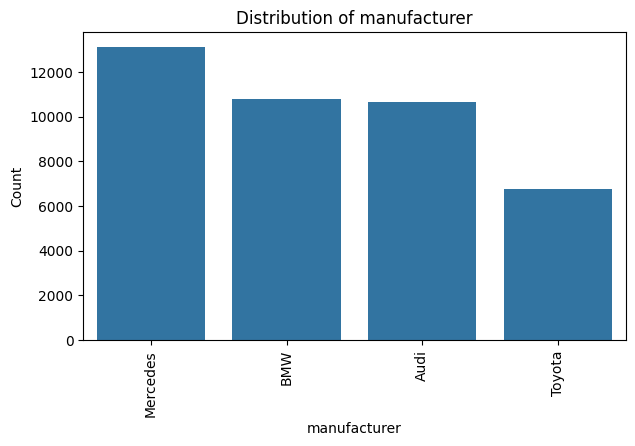

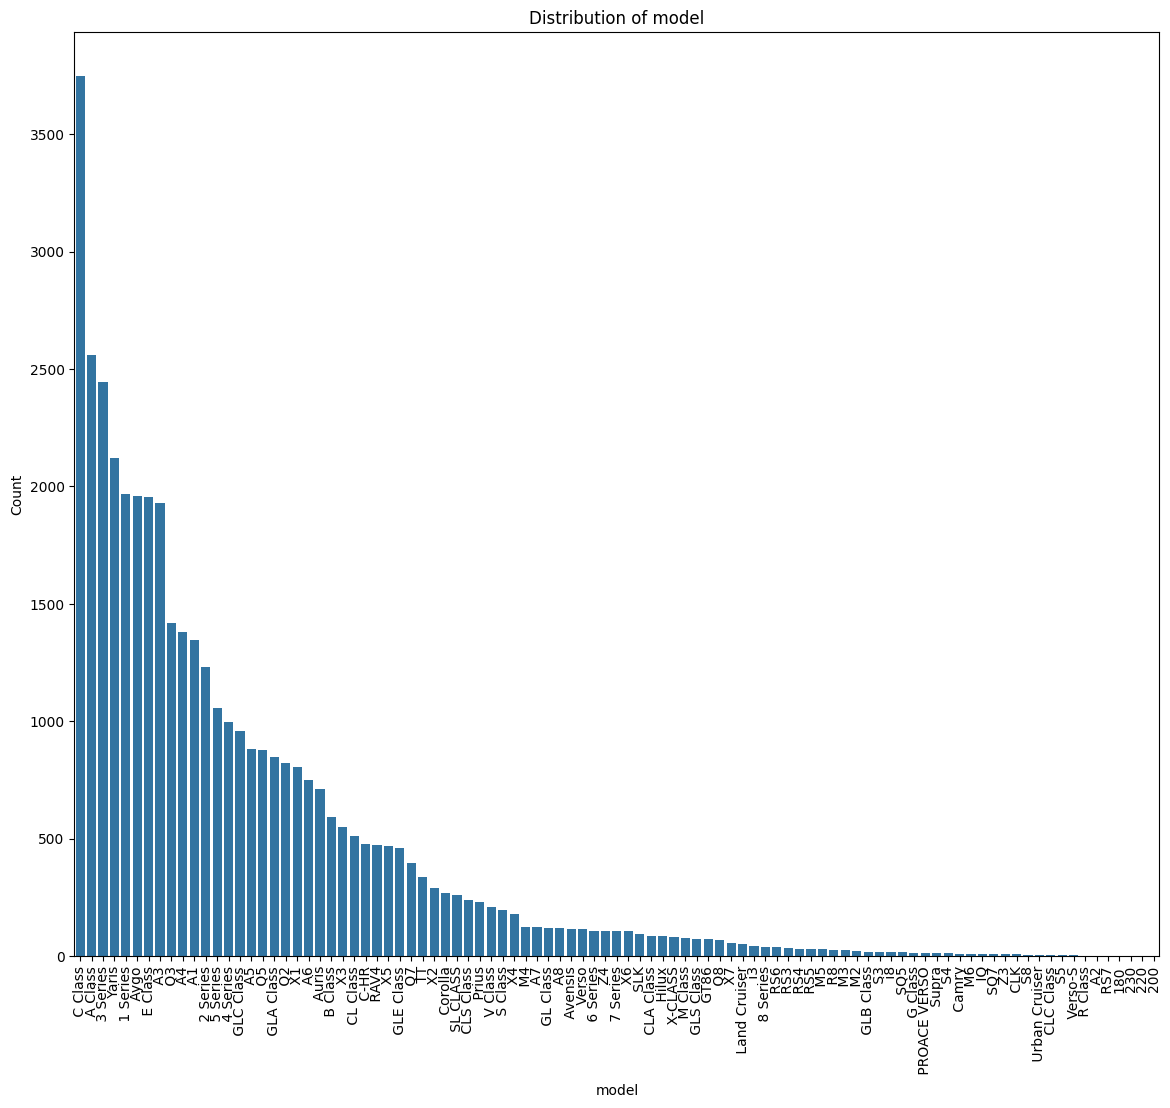

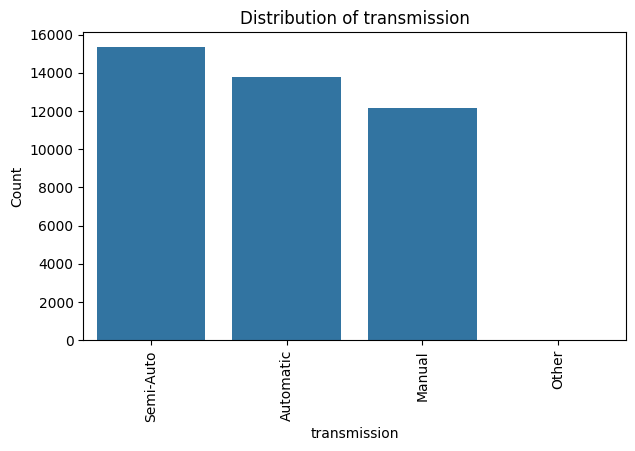

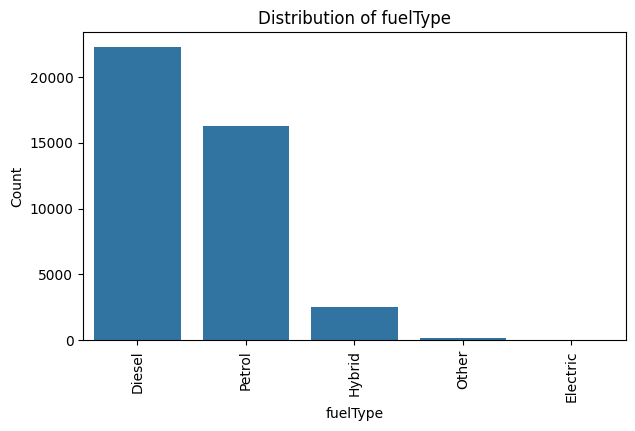

In [ ]:
categorical_columns = X.select_dtypes(include=['object']).columns
print("\nColonne categoriche:", categorical_columns)

for column in categorical_columns:
    print(f"\n{column}")
    print(df[column].unique())
print("\n")

def plot_categorical_distribution(df, categorical_columns):
    for column in categorical_columns:
        if column == 'model':
            plt.figure(figsize=(14, 12))  # Dimensione più grande per la colonna 'model'
        else:
            plt.figure(figsize=(7, 4))

        sns.countplot(x=column, data=df, order=df[column].value_counts().index)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

plot_categorical_distribution(df, categorical_columns)

OneHotEncoding is applied to categorical columns.

Many machine learning models do not work with categorical data, so it is necessary to convert this data into numerical format to make it compatible with the model.

In [ ]:
#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(X[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_X = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
X_encoded = pd.concat([X, one_hot_X], axis=1)

# Drop the original categorical columns
X_encoded = X_encoded.drop(categorical_columns, axis=1)


visualizzazione grafica delle distribuzioni delle feature numeriche restanti con istogrammi

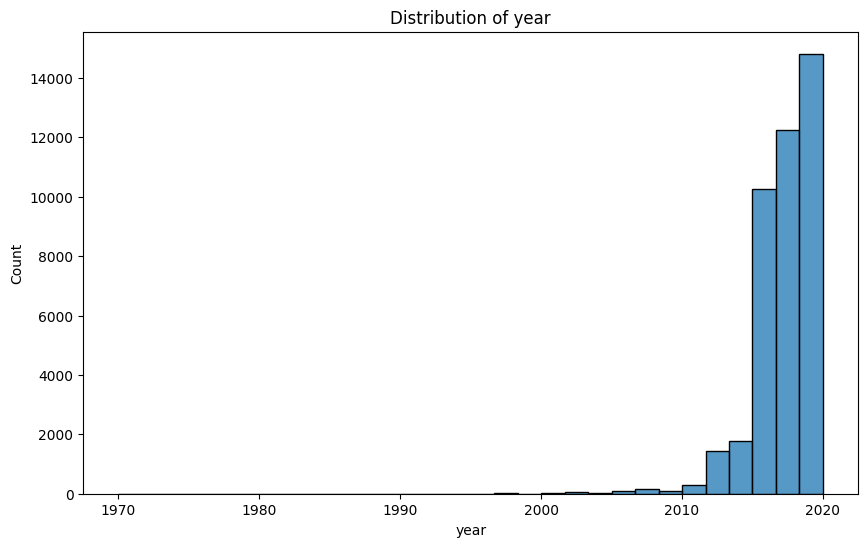

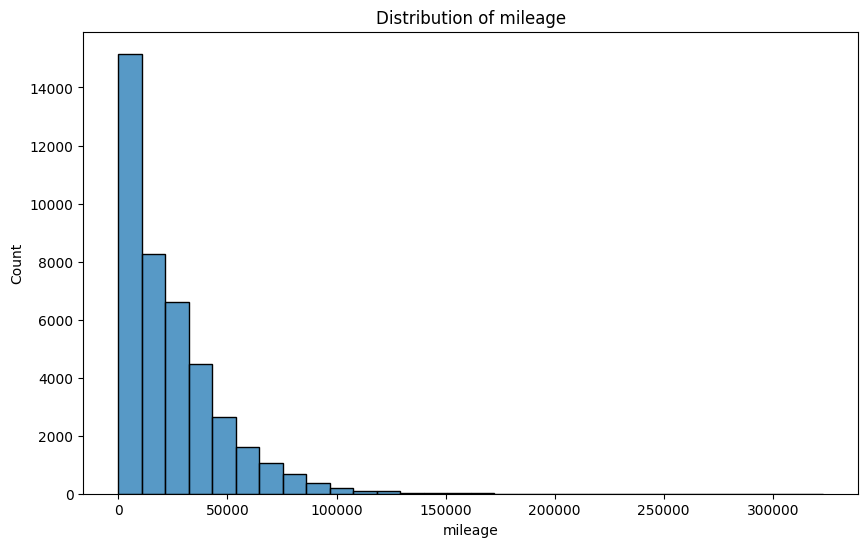

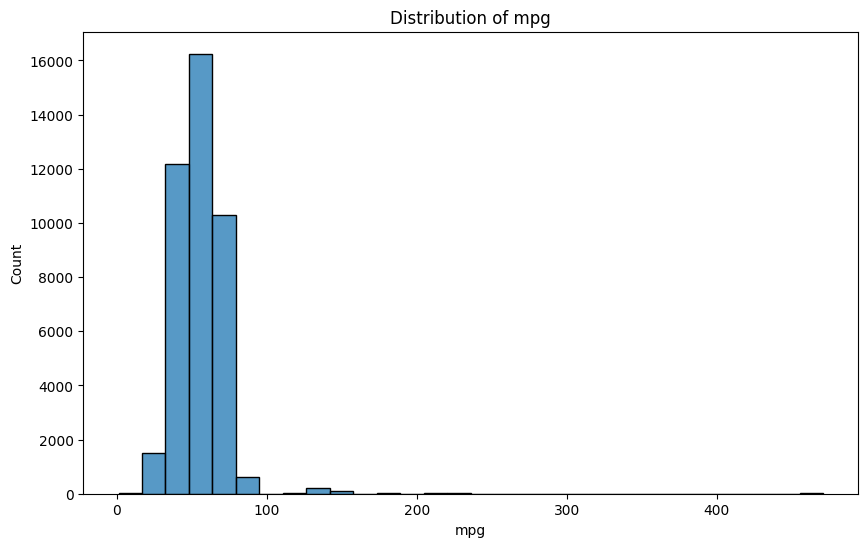

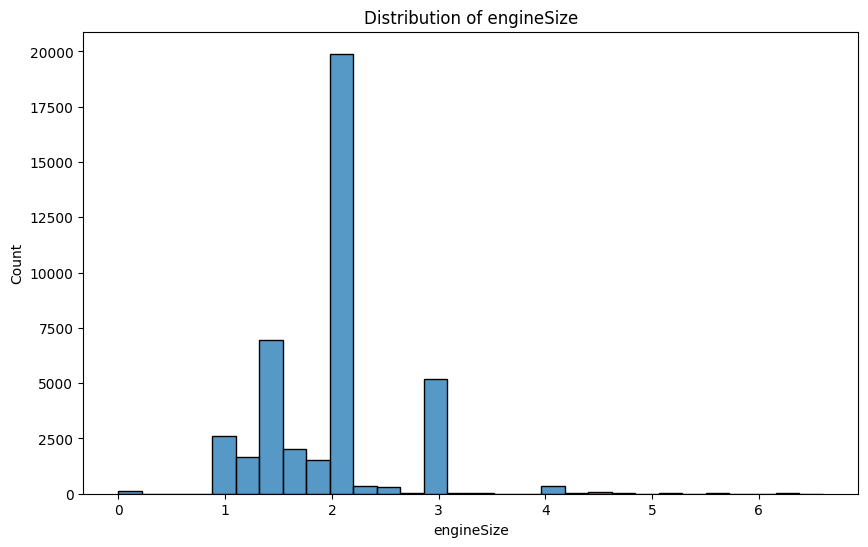

In [ ]:
columns_to_display = ['year', 'mileage', 'mpg', 'engineSize']

def plot_numerical_distribution(df, numerical_columns):
    for column in numerical_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[column], bins=30, kde=False)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()


plot_numerical_distribution(df, columns_to_display)

In [ ]:
X_encoded.describe()

,year,mileage,mpg,engineSize,manufacturer_Audi,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,model_ 1 Series,model_ 2 Series,...,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,...,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000
mean,2017.099622,23766.754733,55.634063,1.962366,0.258268,0.261003,0.317605,0.163124,0.047669,0.029754,...,0.000024,0.333559,0.294533,0.000073,0.371835,0.539728,0.000073,0.061541,0.003583,0.395076
std,2.247246,22627.617263,20.721036,0.602423,0.437687,0.439187,0.465551,0.369483,0.213067,0.169909,...,0.004920,0.471490,0.455838,0.008522,0.483300,0.498425,0.008522,0.240322,0.059752,0.488873
min,1970.000000,1.000000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,6215.500000,45.600000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,17467.500000,54.300000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,34221.250000,64.200000,2.100000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2020.000000,323000.000000,470.800000,6.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###split Dataset
Now, we can split the dataset in **training set and testing set**, using a 80/20 split. Moreover, it's good practice to standardize data to zero mean and unit variance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Models**



##k-nearest neighbors
To evaluate and optimize the performance of a k-Nearest Neighbors (k-NN) model, a combination of k-fold cross-validation was used. This approach provides a reliable estimate of the model's performance and helps in selecting the optimal value for the hyperparameter *k* (number of neighbors).

Best k value: 3
Mean Squared Error: 8717018.41744982
Model results:
Mean Absolute Error (MAE): 1637.6591
R^2 Score: 0.9457



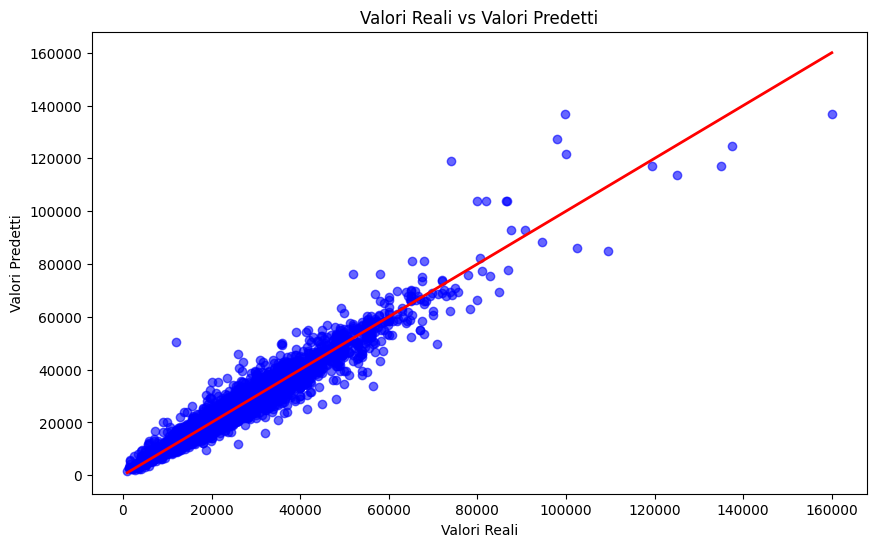

In [ ]:
# Define the number of folds for cross-validation
k = 10  # fold number
kf = KFold(n_splits=k, shuffle=True, random_state=1)

k_values = [1, 3, 5, 7, 10]
best_k = None
best_score = float('inf')

# Perform cross-validation for each k value
for k_value in k_values:
    knn = KNeighborsRegressor(n_neighbors=k_value)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    if mean_score < best_score:
        best_score = mean_score
        best_k = k_value

# Print the best k value and the corresponding mean squared error
print(f"Best k value: {best_k}")
print(f"Mean Squared Error: {best_score}")

# train the model
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

#test the model
y_pred = knn_final.predict(X_test_scaled)
results = modelresults(y_test, y_pred)

neighbors_mae = results['MAE']
neighbors_r2 = results['R2']

# Scatter plot delle predizioni rispetto ai valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Reali vs Valori Predetti')
plt.show()

### Linear regression



Model results:
Mean Absolute Error (MAE): 2985.0145
R^2 Score: 0.8508



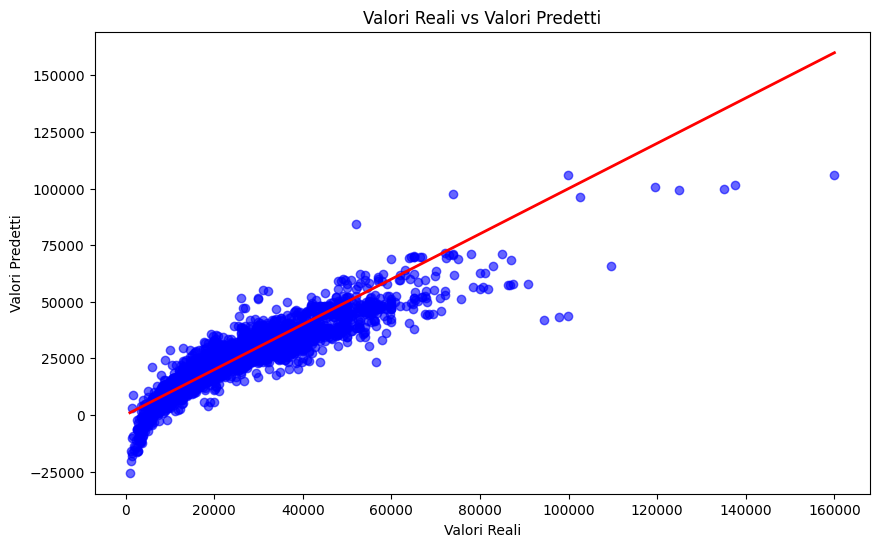

In [ ]:
regressor = LinearRegression()

regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)
results = modelresults(y_test, y_pred)

lr_mae = results['MAE']
lr_r2 = results['R2']

# Scatter plot delle predizioni rispetto ai valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Reali vs Valori Predetti')
plt.show()

###Random Forest Regressor

Model results:
Mean Absolute Error (MAE): 1442.4766
R^2 Score: 0.9582



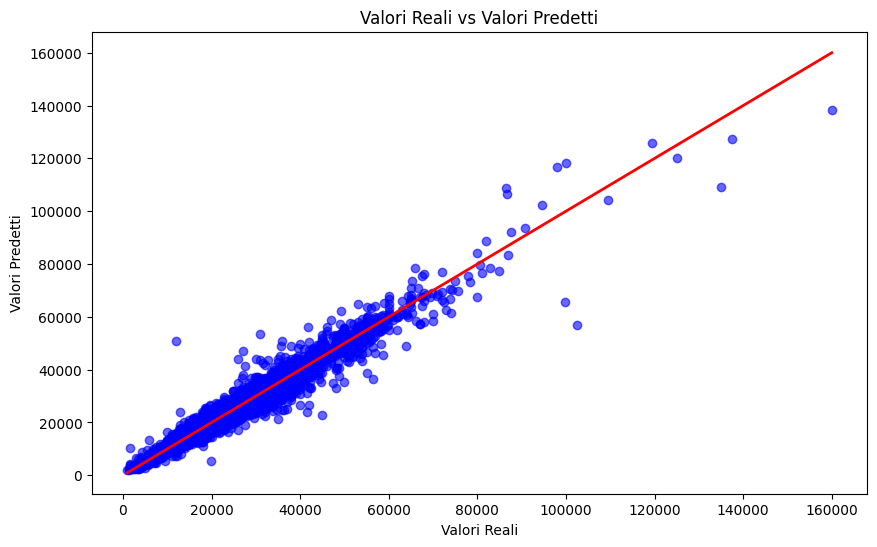

In [ ]:
rfr = RandomForestRegressor(random_state = 1)
rfr.fit(X_train_scaled, y_train)
y_pred = rfr.predict(X_test_scaled)

results = modelresults(y_test, y_pred)

rf_mae = results['MAE']
rf_r2 = results['R2']

# Scatter plot delle predizioni rispetto ai valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Reali vs Valori Predetti')
plt.show()

###Feature selection with Random Forest
With Random Forest we can easily performa feature selection  to identify the most important features (variables) in a dataset that contribute the most to the prediction of the target variable

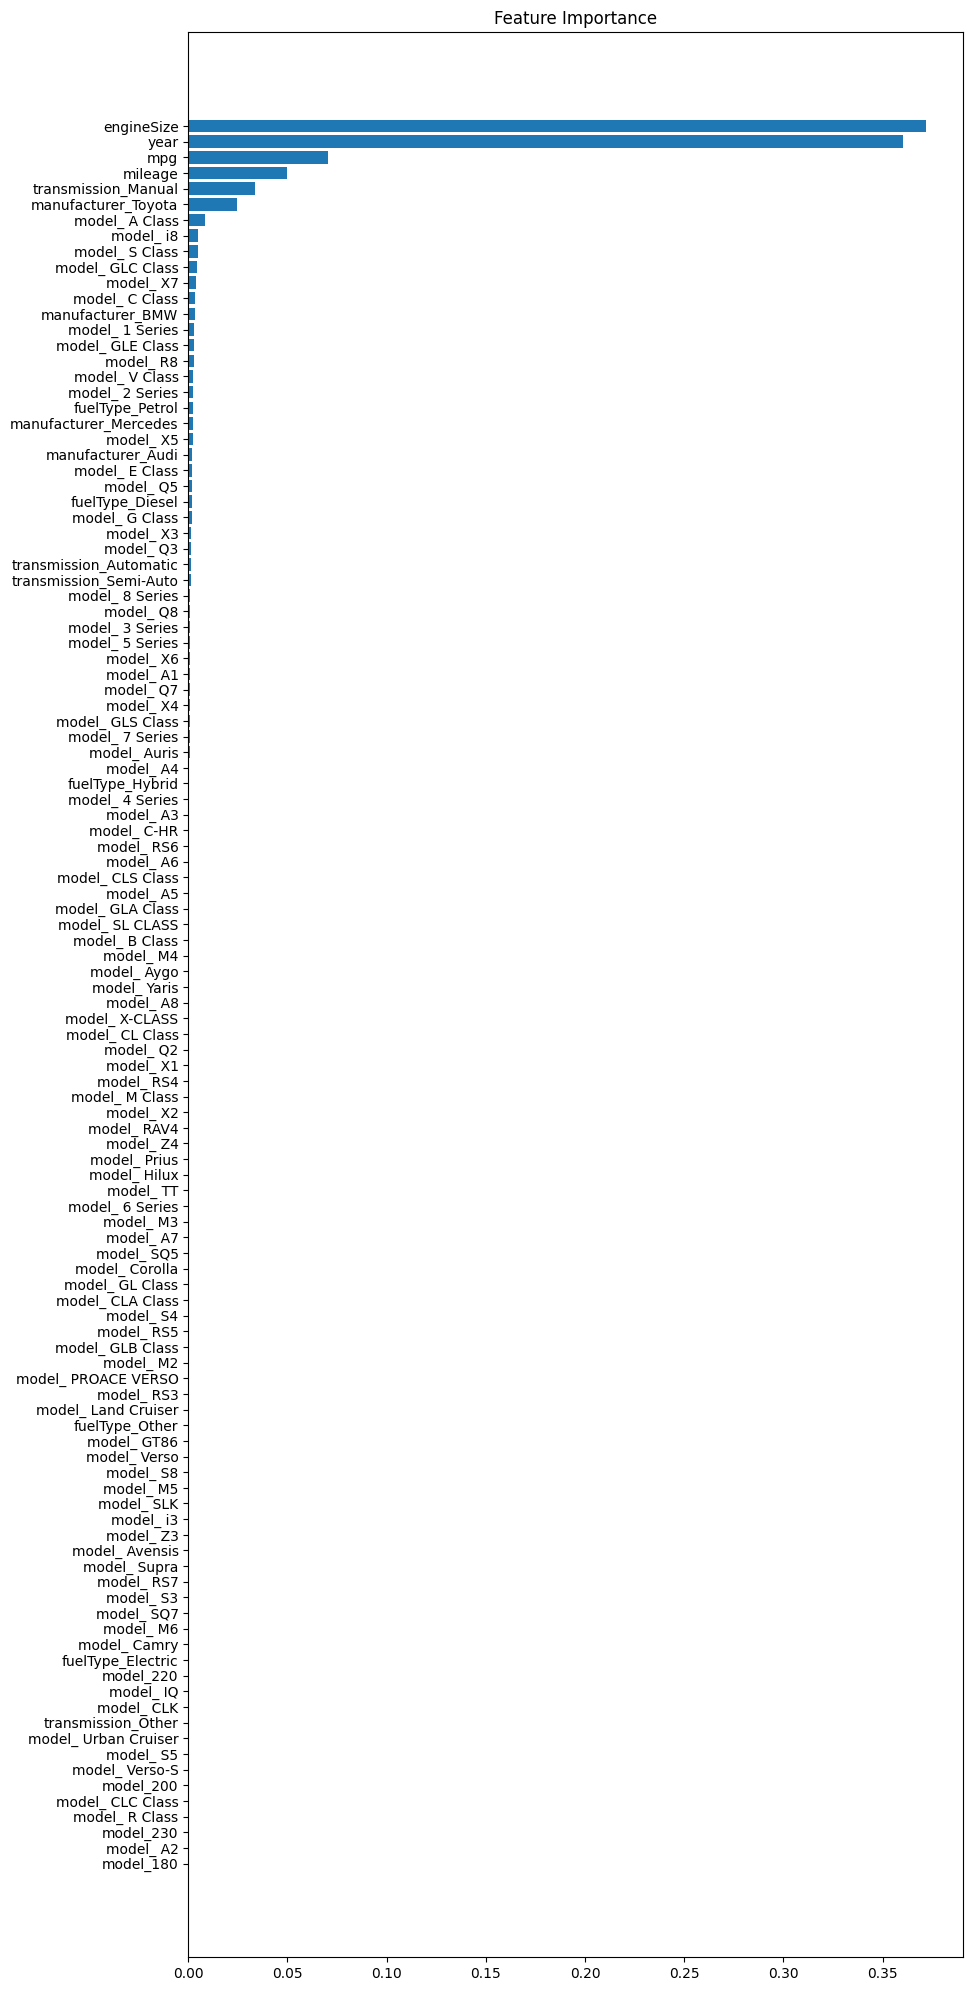

In [ ]:
f_i = list(zip(X_train.columns ,rfr.feature_importances_))
f_i.sort(key = lambda x : x[1])

plt.figure(figsize=(10, 25))
plt.title('Feature Importance')
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

Select the 20 most important features, retrain the model, and evaluate its performance

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(rfr, max_features=20)
sel.get_support()

selected_feat= X_train.columns[(sel.get_support())]

X_train_selected = sel.transform(X_train_scaled)
X_test_selected = sel.transform(X_test_scaled)

rf_fs = RandomForestRegressor(random_state = 1)

rf_fs.fit(X_train_selected, y_train)
predicted_prices_after_fs = rf_fs.predict(X_test_selected)
results = modelresults(y_test, predicted_prices_after_fs)


Model results:
Mean Absolute Error (MAE): 2150.4130
R^2 Score: 0.9061



As we can see, after performing feature selection, the performance of the Random Forest model is as follows:

-)Without feature selection:

Errore Assoluto Medio (MAE): 1483.5672

R² Score: 0.9563


-)With feature selection:

Errore Assoluto Medio (MAE): 2150.4130

R² Score: 0.9061

**These changes indicate that the exclusion of certain features may have removed important information that contributed to the model's predictive power **

###Neural Network
We define a function to create a neural network model with hyperparameter tuning capabilities.
The function returns the compiled model, ready for training and evaluation.

In [ ]:
def create_NN_model(hp):
  model = Sequential()
  #input layer
  model.add(keras.Input(shape=(X_train.shape[1],)))

  #tunable number of layers
  for i in range(hp.Int("num_layers", 1, 5)):
    model.add(
        Dense(
        units=hp.Int(f"units_{i}", min_value=10, max_value=100, step=10),
                activation="relu",
                kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'random_normal', 'glorot_uniform', 'he_normal'])
          )
    )

  #output layer
  model.add(
      Dense(units=1,
            kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'random_normal', 'glorot_uniform', 'he_normal']),
            activation='linear')
      )

  #tunable learning rate
  learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

  # Compile the model
  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss='mean_absolute_error',
      metrics=['mean_absolute_error']
  )

  return model


This code sets up a hyperparameter tuning process for a neural network model using a RandomSearch tuner. It tests different hyperparameter combinations to minimize the validation mean absolute error, with a maximum of 3 trials.

In [ ]:
tuner = RandomSearch(
    create_NN_model,
    objective='val_mean_absolute_error',
    max_trials=5,  # Number of different hyperparameter combinations to try
    directory='/content/drive/My Drive/tuning',
    project_name='ml-project2'
)


tuner.search(
    X_train_scaled, y_train,
    epochs=350,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)]
)

# summary
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model.summary()
print("")
tuner.results_summary()

Trial 5 Complete [00h 02m 05s]
val_mean_absolute_error: 1730.8890380859375

Best val_mean_absolute_error So Far: 1730.8890380859375
Total elapsed time: 00h 46m 52s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40)                  │           4,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             410 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,291 (20.67 KB)

 Trainable params: 5,291 (20.67 KB)

 Non-trainable params: 0 (0.00 B)


Results summary
Results in /content/drive/My Drive/tuning/ml-project2
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 4 summary
Hyperparameters:
num_layers: 3
units_0: 40
initializer: glorot_normal
learning_rate: 0.1
units_1: 10
units_2: 30
units_3: 50
units_4: 50
Score: 1730.8890380859375

Trial 2 summary
Hyperparameters:
num_layers: 4
units_0: 20
initializer: he_normal
learning_rate: 0.1
units_1: 70
units_2: 40
units_3: 70
units_4: 10
Score: 1875.968017578125

Trial 1 summary
Hyperparameters:
num_layers: 3
units_0: 70
initializer: he_normal
learning_rate: 1e-05
units_1: 80
units_2: 40
units_3: 30
units_4: 80
Score: 2174.81103515625

Trial 0 summary
Hyperparameters:
num_layers: 5
units_0: 10
initializer: glorot_normal
learning_rate: 0.01
units_1: 10
units_2: 10
units_3: 10
units_4: 10
Score: 2189.624267578125

Trial 3 summary
Hyperparameters:
num_layers: 2
units_0: 90
initializer: glorot_normal
learning_rate: 1e-05
units_1: 60
units_2: 80
unit

Once the tuning is complete, we can obtain the best hyperparameters.

In [ ]:
from IPython.display import Markdown, display

units = []
for i in range(0, best_hps.get("num_layers")):
  units.append(best_hps.get(f"units_{i}"))

hyp_string = f"""
The hyperparameter search is complete.
* the optimal number of layers is {best_hps.get("num_layers")};
* the optimal number of units in each layer is: {' '.join(str(unit) for unit in units)};
* the optimal initializer is {best_hps.get("initializer")};
* the optimal learning rate is {best_hps.get("learning_rate")};
"""

def printmd(string):
    display(Markdown(string))

printmd(hyp_string)


The hyperparameter search is complete.
* the optimal number of layers is 3;
* the optimal number of units in each layer is: 40 10 30;
* the optimal initializer is glorot_normal;
* the optimal learning rate is 0.1;


 And we train the best model on our training set:

In [ ]:
best_model.fit(X_train_scaled, y_train, epochs=350, batch_size=32)

Epoch 1/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1825.4731 - mean_absolute_error: 1825.4731
Epoch 2/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1919.4493 - mean_absolute_error: 1919.4493
Epoch 3/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1812.4242 - mean_absolute_error: 1812.4242
Epoch 4/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1798.8689 - mean_absolute_error: 1798.8689
Epoch 5/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1823.7642 - mean_absolute_error: 1823.7642
Epoch 6/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1825.1676 - mean_absolute_error: 1825.1676
Epoch 7/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1818.4293 - mean_absolute_error: 1818.4293
Epoch 8/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1791.9326 - mean_absolute_error: 1791.9326
Epoch 9/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1804.6519 - mean_absolute_error: 1804.6519
Epoch 10/350
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 

Let's see the neural network performances on the testing set:

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Model results:
Mean Absolute Error (MAE): 1611.2123
R^2 Score: 0.9497



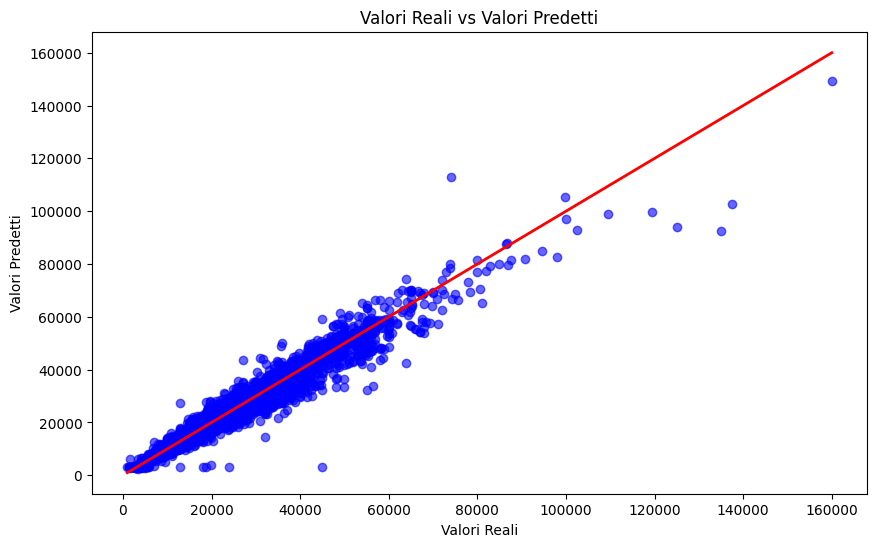

In [ ]:
y_pred = best_model.predict(X_test_scaled)
results = modelresults(y_test, y_pred)

nn_mae = results['MAE']
nn_r2 = results['R2']

# Scatter plot delle predizioni rispetto ai valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Reali vs Valori Predetti')
plt.show()

##**Models evaluation**
The following graphs compare the performance of the models seen, according to the metrics defined in the introduction:

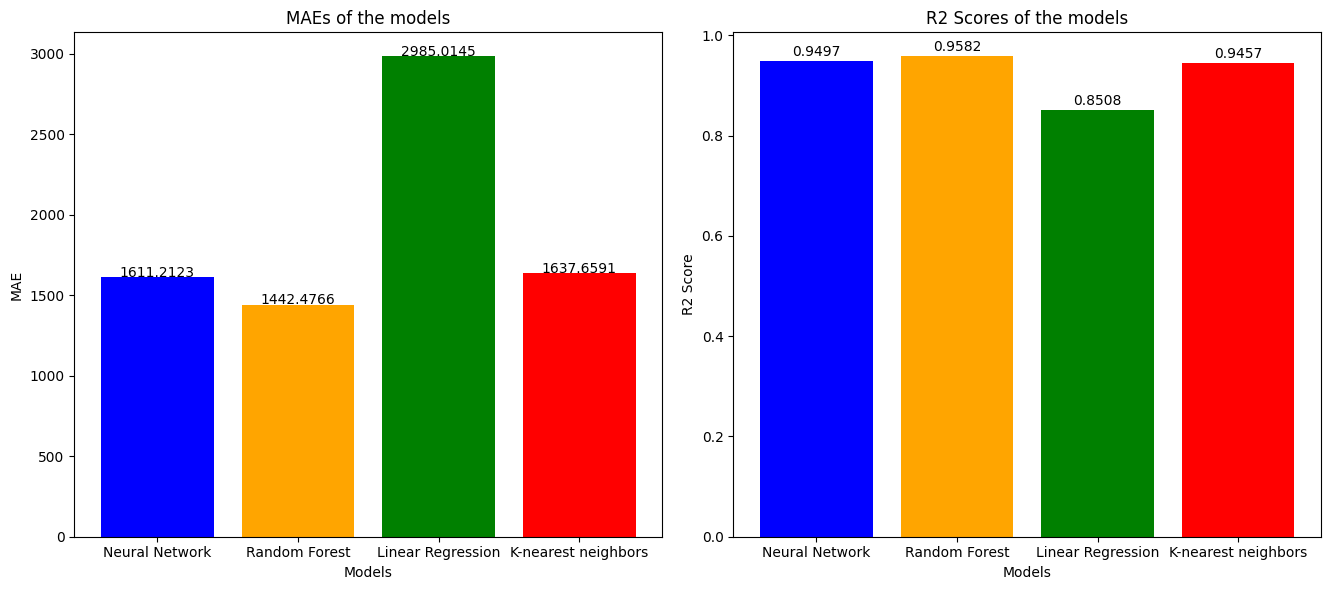

In [ ]:
model_names = ['Neural Network', 'Random Forest', 'Linear Regression', 'K-nearest neighbors']
mae_values = [nn_mae, rf_mae, lr_mae, neighbors_mae]
r2_values = [nn_r2, rf_r2, lr_r2, neighbors_r2]


# MAE
plt.figure(figsize=(20, 6))
plt.subplot(131)
bars = plt.bar(model_names, mae_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('MAEs of the models')

for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.4f}', ha='center', color='black')

# R2 score
plt.subplot(132)
bars = plt.bar(model_names, r2_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Scores of the models')

for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.4f}', ha='center', color='black')

plt.tight_layout()
plt.show()

In [ ]:
best_MAE = model_names[np.argmin(mae_values)]
best_r2 = model_names[np.argmax(r2_values)]

string = f"""
Model with the lowest MAE:
* {best_MAE}

Model with the highest $R^2$ Score:
* {best_r2}
"""

display(Markdown(string))


Model with the lowest MAE:
* Random Forest

Model with the highest $R^2$ Score:
* Random Forest


For this regression task, the best model is **Random Forest**